## An easy-to-use notebook for beginners:
1. Define ImageBind model
2. Define Diffusion model
3. Audio-conditioned image generation
4. Audio-conditioned image editing

In [1]:
""" importing modules
"""
import torch
from PIL import Image
import numpy as np
import os
from omegaconf import OmegaConf
from easydict import EasyDict
import matplotlib.pyplot as plt

import imagebind.data as data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

from ldm.models.diffusion.ddpm import ImageEmbeddingConditionedLatentDiffusion
from ldm.models.diffusion.ddim import DDIMSampler

/root/miniconda3/envs/imagebind/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/root/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


No module 'xformers'. Proceeding without it.


### 1. Define ImageBind model

In [2]:
class Binder:
    """ Wrapper for imagebind model
    """
    def __init__(self, pth_path, device='cuda'):
        self.model = imagebind_model.imagebind_huge(pretrained=True)
        self.device = device
        self.model.eval()
        self.model.to(device)

        self.data_process_dict = {ModalityType.TEXT: data.load_and_transform_text,
                                  ModalityType.VISION: data.load_and_transform_vision_data,
                                  ModalityType.AUDIO: data.load_and_transform_audio_data}

    def run(self, ctype, cpaths, post_process=False):
        """ ctype: str
            cpaths: list[str]
        """
        inputs = {ctype: self.data_process_dict[ctype](cpaths, self.device)}
        with torch.no_grad():
            embeddings = self.model(inputs)

        return embeddings[ctype]

device = 'cuda'
binder = Binder(pth_path="imagebind/.checkpoints/imagebind_huge.pth", device=device)

### 2. Define Diffusion model

In [3]:
import imagebind.models.imagebind_model
print(dir(imagebind.models.imagebind_model))

['AudioPreprocessor', 'EinOpsRearrange', 'IMUPreprocessor', 'ImageBindModel', 'LearnableLogitScaling', 'ModalityType', 'MultiheadAttention', 'Normalize', 'PadIm2Video', 'PatchEmbedGeneric', 'RGBDTPreprocessor', 'SelectEOSAndProject', 'SelectElement', 'SimpleNamespace', 'SimpleTransformer', 'SpatioTemporalPosEmbeddingHelper', 'TextPreprocessor', 'ThermalPreprocessor', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'imagebind_huge', 'nn', 'os', 'partial', 'torch']


In [12]:
config.model['params']

{'embedding_dropout': 0.25, 'parameterization': 'v', 'linear_start': 0.00085, 'linear_end': 0.012, 'log_every_t': 200, 'timesteps': 1000, 'first_stage_key': 'jpg', 'cond_stage_key': 'txt', 'image_size': 96, 'channels': 4, 'cond_stage_trainable': False, 'conditioning_key': 'crossattn-adm', 'scale_factor': 0.18215, 'monitor': 'val/loss_simple_ema', 'use_ema': False, 'depth_stage_config': {'target': 'ldm.modules.midas.api.MiDaSInference', 'params': {'model_type': 'dpt_hybrid'}}, 'embedder_config': {'target': 'imagebind.models.imagebind_model.imagebindEmbedder'}, 'noise_aug_config': {'target': 'ldm.modules.encoders.modules.CLIPEmbeddingNoiseAugmentation', 'params': {'timestep_dim': 1024, 'noise_schedule_config': {'timesteps': 1000, 'beta_schedule': 'squaredcos_cap_v2'}}}, 'unet_config': {'target': 'ldm.modules.diffusionmodules.openaimodel.UNetModel', 'params': {'num_classes': 'sequential', 'adm_in_channels': 2048, 'use_checkpoint': True, 'image_size': 32, 'in_channels': 4, 'out_channels': 

In [14]:
config['embedder_config']['target'] 

ConfigKeyError: Missing key embedder_config
    full_key: embedder_config
    object_type=dict

In [4]:
# options
opt = EasyDict(config = 'configs/stable-diffusion/v2-1-stable-unclip-h-bind-inference.yaml',
               device = device,
               ckpt = 'checkpoints/sd21-unclip-h.ckpt',
               C = 4,
               H = 768,
               W = 768,
               f = 8,
               steps = 50, 
               n_samples = 1,
               scale = 20,
               ddim_eta = 0,
               )

config = OmegaConf.load(f"{opt.config}")
shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
batch_size = opt.n_samples

# prepare diffusion model
model = ImageEmbeddingConditionedLatentDiffusion(**config.model['params'])
pl_sd = torch.load(opt.ckpt, map_location="cpu")
sd = pl_sd["state_dict"]
model.load_state_dict(sd, strict=False)
model.to(opt.device)
model.eval()

sampler = DDIMSampler(model, device=opt.device)

ImageEmbeddingConditionedLatentDiffusion: Running in v-prediction mode
DiffusionWrapper has 870.17 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [5]:
def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

### 3. Audio-conditioned image generation

In [8]:
prompts = ['colorful, DSLR quality, clear, vivid'] * batch_size    # you may add extra descriptions you like here
c_adm = binder.run(ctype='audio', cpaths=['assets/bird_audio.wav'], post_process=False)
c_adm = c_adm / c_adm.norm() * 20   # a norm of 20 typically gives better result 
c_adm = torch.cat([c_adm] * batch_size, dim=0)

with torch.no_grad(), torch.autocast('cuda'):
    
    c_adm, noise_level_emb = model.noise_augmentor(c_adm, noise_level=torch.zeros(batch_size).long().to(c_adm.device))
    c_adm = torch.cat((c_adm, noise_level_emb), 1)

    uc = model.get_learned_conditioning(batch_size * ["text, watermark, blurry, number"])    # negative prompts
    uc = {"c_crossattn": [uc], "c_adm": torch.zeros_like(c_adm)}
    c = {"c_crossattn": [model.get_learned_conditioning(prompts)], "c_adm": c_adm}

    samples, _ = sampler.sample(S=opt.steps,
                                conditioning=c,
                                batch_size=batch_size,
                                shape=shape,
                                verbose=False,
                                unconditional_guidance_scale=opt.scale,
                                unconditional_conditioning=uc,
                                eta=opt.ddim_eta,
                                x_T=None)

x_samples = model.decode_first_stage(samples)
x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
plt.imshow(x_samples[0].permute(1,2,0).cpu().numpy())


TypeError: forward() got an unexpected keyword argument 'post_process'

### 4. Audio-conditioned image editing

loaded input image of size (1024, 512) from stablediffusion/assets/stable-samples/img2img/sketch-mountains-input.jpg
Running DDIM Sampling with 37 timesteps


Decoding image: 100%|██████████| 37/37 [00:05<00:00,  6.68it/s]


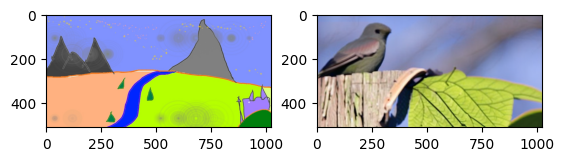

In [52]:
prompts = ['colorful, DSLR quality, clear, vivid'] * batch_size    # you may add extra descriptions you like here
c_adm = binder.run(ctype='audio', cpaths=['imagebind/.assets/bird_audio.wav'], post_process=False)
c_adm = c_adm / c_adm.norm() * 20   # a norm of 20 typically gives better result 
c_adm = torch.cat([c_adm] * batch_size, dim=0)

init_img = 'stablediffusion/assets/stable-samples/img2img/sketch-mountains-input.jpg'    # image to be edited
strength = .75    # editing strength
t_enc = int(strength * opt.steps)

sampler.make_schedule(ddim_num_steps=opt.steps, ddim_eta=opt.ddim_eta, verbose=False)


with torch.no_grad(), torch.autocast('cuda'):
    c_adm, noise_level_emb = model.noise_augmentor(c_adm, noise_level=torch.zeros(batch_size).long().to(c_adm.device))
    # assume this gives embeddings of noise levels
    c_adm = torch.cat((c_adm, noise_level_emb), 1)

    uc = model.get_learned_conditioning(batch_size * [""])
    uc = {"c_crossattn": [uc], "c_adm": torch.zeros_like(c_adm)}
    c = {"c_crossattn": [model.get_learned_conditioning(prompts)], "c_adm": c_adm}


    init_image = load_img(init_img).to(device)
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space
    z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc] * batch_size).to(device))

    # decode it
    samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                             unconditional_conditioning=uc, )


x_samples = model.decode_first_stage(samples)
x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
plt.subplot(121)
plt.imshow((init_image[0].permute(1,2,0).cpu().numpy()+1)/2)
plt.subplot(122)
plt.imshow(x_samples[0].permute(1,2,0).cpu().numpy())